코드의 목적: Bias-Variance Tradeoff에 대한 간단한 이해

DGP: $$ y = x^4  - 21 x^3 + 149 x^2 - 399 x + 200 + \epsilon$$

x ~ Uniform Distribution [0, 10]

ϵ ~ N(0, 30)

모집단에 대한 분포를 모른다고 가정하고, 여러 차수의 함수로 fitting 해보기

### 1. General Setting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from collections import defaultdict

In [2]:
# E[x]
def true_function(x):
    return x**4 - 21*x**3 + 149*x**2 - 399*x + 200

# 데이터 생성 (with noise)
def generate_data(n_samples, noise=30):
    X = np.random.uniform(0, 10, n_samples)
    y = true_function(X) + np.random.normal(0, noise, n_samples)
    return X, y

# 다항 회귀 모델 피팅
def fit_polynomial(X_train, y_train, degree):
    polynomial_features = PolynomialFeatures(degree=degree)
    X_train_poly = polynomial_features.fit_transform(X_train.reshape(-1, 1))
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    return model

def predict_polynomial(X_test, model, degree):
    polynomial_features = PolynomialFeatures(degree=degree)
    X_test_poly = polynomial_features.fit_transform(X_test.reshape(-1, 1))
    y_pred = model.predict(X_test_poly)
    return y_pred

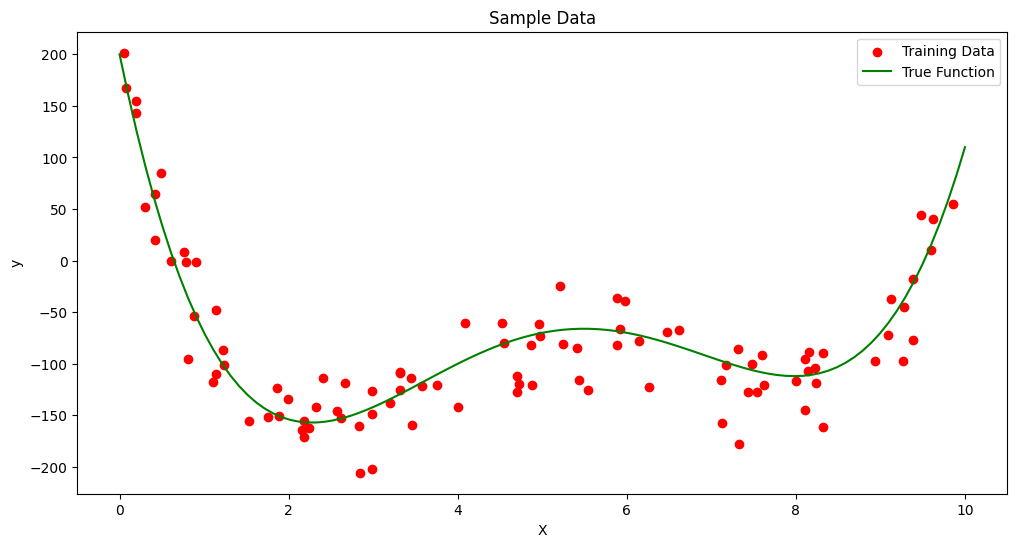

In [3]:
#Sample Data
X_train, y_train = generate_data(100)
plt.figure(figsize=(12, 6))
plt.scatter(X_train, y_train, color='red', label='Training Data')
plt.plot(np.linspace(0, 10, 100), true_function(np.linspace(0, 10, 100)), color='green', label='True Function')
plt.title('Sample Data')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

### 2. Train

In [4]:
def plot_sample_fitted(degree, n_samples):
    X_train, y_train = generate_data(n_samples)
    model = fit_polynomial(X_train, y_train, degree)
    y_pred_train = predict_polynomial(X_train, model, degree)

    plt.figure(figsize=(12, 6))
    plt.scatter(X_train, y_train, color='red', label='Train Data')
    plt.scatter(X_train, y_pred_train, color='blue', label='Sample Fitted Value with degree '+str(degree))
    plt.plot(np.linspace(0, 10, 100), true_function(np.linspace(0, 10, 100)), color='green', label='True Function')
    plt.title('Sample Data')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.show()

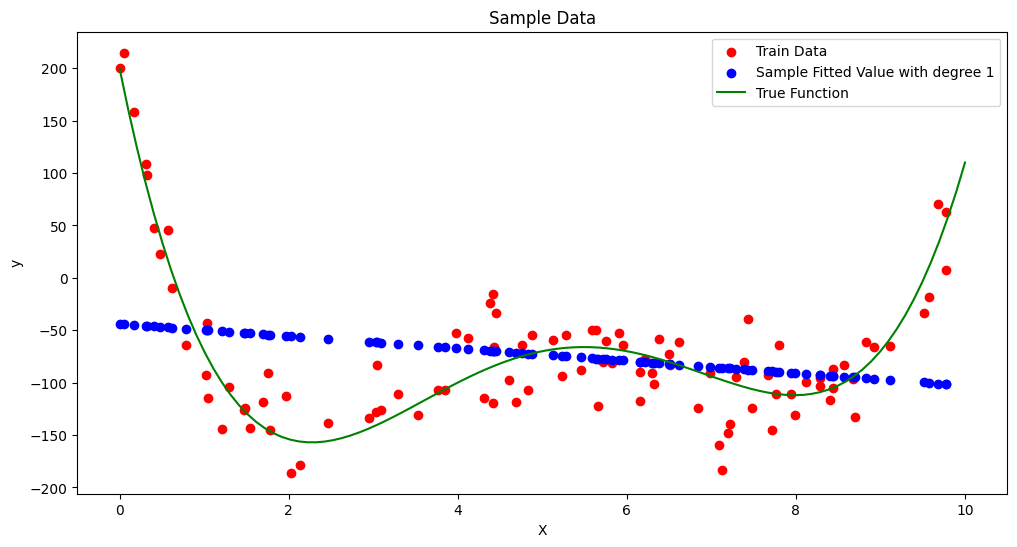

In [5]:
plot_sample_fitted(1, 100)

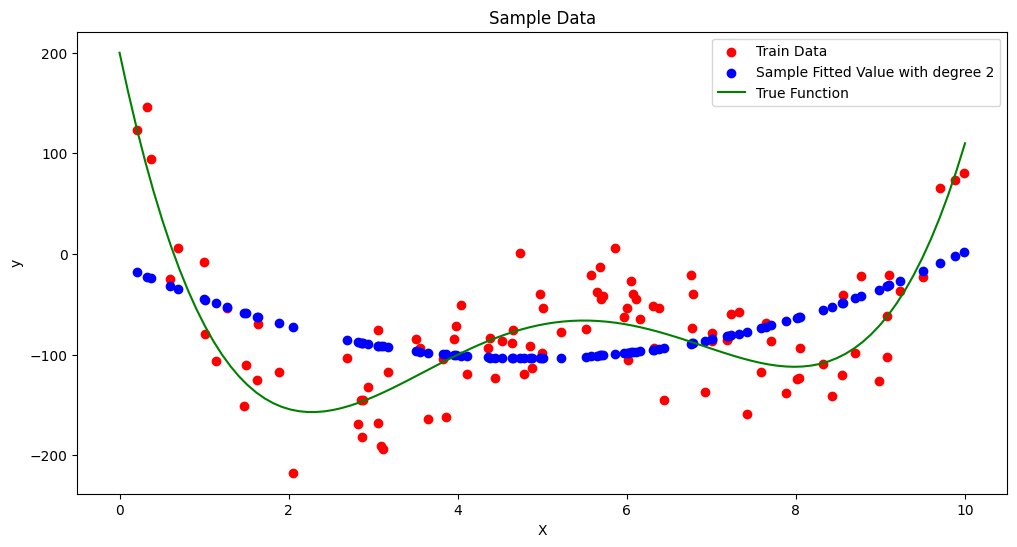

In [6]:
plot_sample_fitted(2, 100)

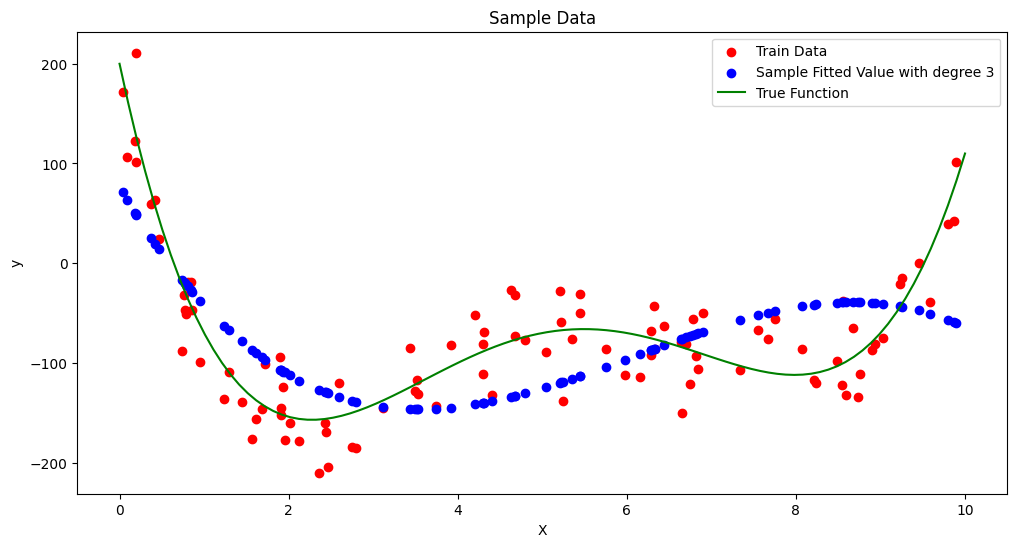

In [7]:
plot_sample_fitted(3, 100)

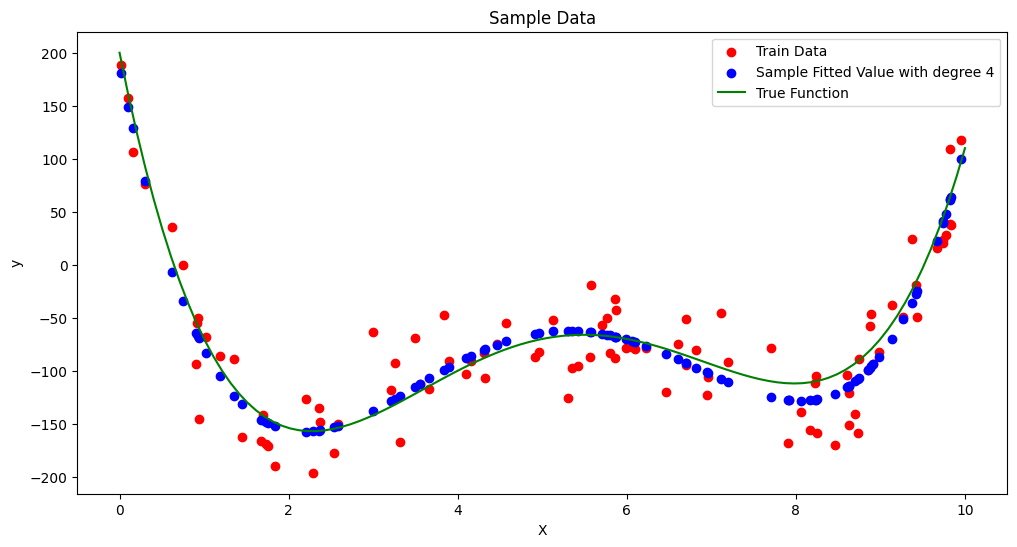

In [8]:
plot_sample_fitted(4, 100)

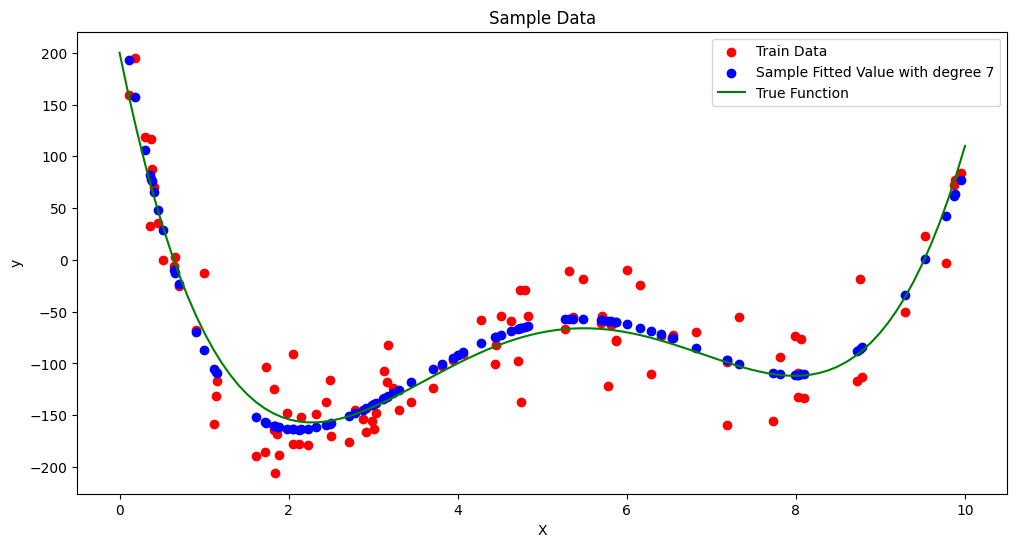

In [9]:
plot_sample_fitted(7, 100)

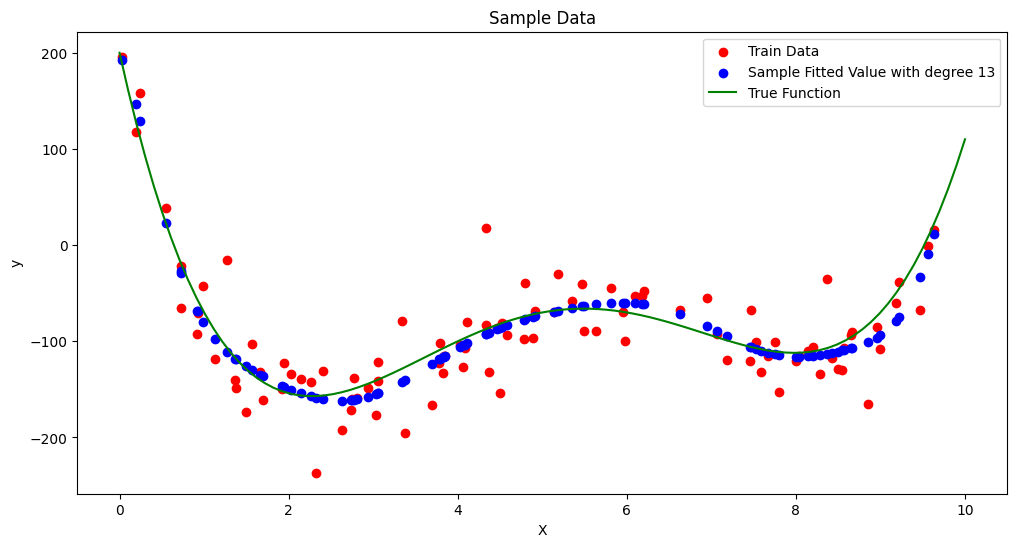

In [10]:
plot_sample_fitted(13, 100)

In [11]:
degrees = list(range(1, 14))  # 시도해볼 회귀식의 차수.
y_pred_test_dict = defaultdict(list)

#y_pred_test의 분포를 알기 위해서,
#우리가 50개의 샘플을 관측할 수 있는 세상을 1000번 산다는 가정을 두었고,
#50개의 샘플을 이용하여 1000개의 모델을 트레인 하여, y_pred_test의 셋을 1000개를 뽑아냄.
#test set은 1000개의 샘플을 기준으로 하였음.

np.random.seed(1)
X_test, y_test = generate_data(1000)
for _ in range(1000):
    X_train, y_train = generate_data(50)
    for degree in degrees:
        model = fit_polynomial(X_train, y_train, degree)
        y_pred_test = predict_polynomial(X_test, model, degree)
        y_pred_test_dict[degree].append(y_pred_test)

### 3. Test Set RMSE 확인하기

In [12]:
test_rmse_dict = defaultdict(list)
for degree in degrees:
    for i, y_pred_test in enumerate(y_pred_test_dict[degree]):
        test_rmse_dict[degree].append((mean_squared_error(y_test, y_pred_test))**(1/2))

In [13]:
test_rmse_df = pd.DataFrame(test_rmse_dict)

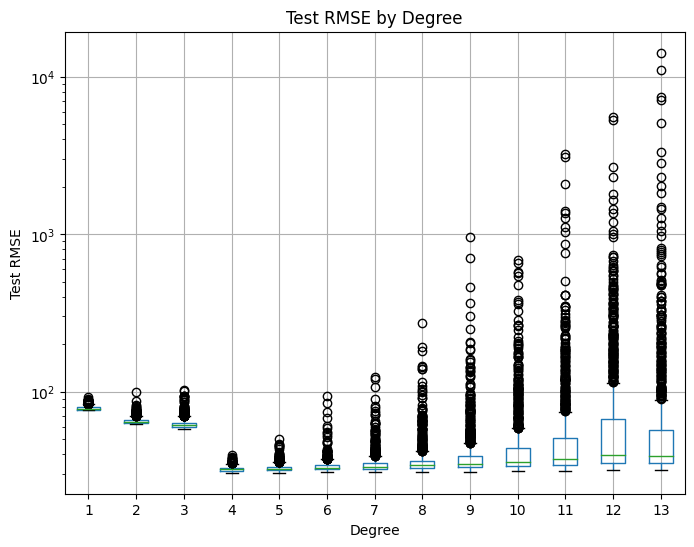

In [14]:
plt.figure(figsize=(8, 6))
test_rmse_df.boxplot()
plt.xlabel('Degree')
plt.ylabel('Test RMSE')
plt.title('Test RMSE by Degree')

plt.yscale('log')

plt.show()

In [15]:
test_rmse_df.describe()
#Test Set의 RMSE의 경우 degree가 4일때 가장 낮으며,
#Degree가 1일 때는 RMSE는 높으나 model별 RMSE 차이는 크지 않음
#Degree가 커지면 RMSE의 std도 기하급수적으로 증가함

,1,2,3,4,5,6,7,8,9,10,11,12,13
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,78.575350,64.823532,62.609490,32.275476,32.880672,33.712916,35.168569,37.714583,43.397625,50.848213,70.581348,102.752924,131.782128
std,2.254139,3.157279,5.176602,1.217873,1.925813,4.049365,7.240794,15.157589,45.069983,55.006702,184.014360,301.475996,701.888163
min,76.380677,61.916569,57.905044,30.541250,30.636122,30.698145,30.761198,30.925619,30.942481,31.206456,31.479314,31.630864,31.698491
25%,76.965497,62.879853,59.575686,31.374039,31.739437,32.054008,32.415631,32.784001,33.206353,33.680143,34.199357,35.298858,35.069329
50%,77.840791,63.813095,60.957508,32.026379,32.451902,32.922202,33.329883,33.987525,34.662420,35.761959,37.071891,39.673506,38.951865
75%,79.411147,65.723640,63.649346,32.817166,33.385762,34.138478,35.107424,36.359475,38.866589,43.749394,50.422275,66.829578,56.964932
max,92.223878,99.291442,101.878401,39.561989,49.967621,94.003104,124.267573,274.462414,965.267750,688.795992,3215.550669,5580.278349,14204.606565


### 4. Bias - Variance 비교

Bias-Variance Decomposition:

$$Expected Loss = E[(f(x) - f^{\hat{}}(x))^2] = (Bias[f^{\hat{}}(x)])^2 + Variance[f^{\hat{}}(x)] + Irreducible Error$$



- f(x): 실제 함수 (True Function)
- f^(x): 모델의 예측 함수 (Estimated Function)
- Expected Loss: 예측 모델의 평균적인 오차 (Expected Value of the Loss Function)
- Bias[f^(x)]: 모델의 예측 함수와 실제 함수 간의 차이를 나타내는 오차 (Bias)
- Variance[f^(x)]: 모델의 예측 함수의 변동성을 나타내는 오차 (Variance)
- Irreducible Error: 모델로부터 제거할 수 없는 오차로, 데이터 자체에 내재된 잡음이나 불확실성


In [16]:
mean_squared_error(y_test,true_function(X_test)) #irreducible error

935.2847608832168

In [17]:
# Bias 계산
def calculate_bias(y_true, y_pred_list):
    mean_pred = np.mean(y_pred_list, axis=0)
    return np.mean((y_true - mean_pred) ** 2)

# Variance 계산
def calculate_variance(y_pred_list):
    mean_pred = np.mean(y_pred_list, axis=0)
    return np.mean((y_pred_list - mean_pred) ** 2)


In [18]:
dict_bias = defaultdict(int)
dict_variance = defaultdict(int)
for degree in degrees:
    dict_bias[degree] = calculate_bias(true_function(X_test), y_pred_test_dict[degree])
    dict_variance[degree] = calculate_variance(y_pred_test_dict[degree])


In [19]:
df_bias_variance = pd.DataFrame([dict_bias.values(), dict_variance.values()], columns=dict_bias.keys()).T
df_bias_variance.columns = ["Bias", "Variance"]

<Figure size 2000x1000 with 0 Axes>

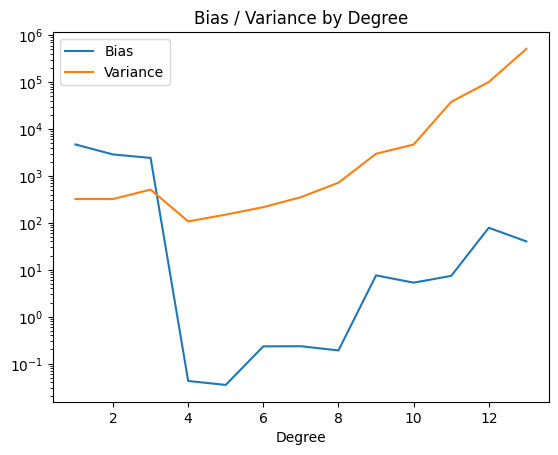

In [20]:
plt.figure(figsize=(20, 10))
df_bias_variance.plot()
plt.xlabel('Degree')
plt.title('Bias / Variance by Degree')

plt.yscale('log')

plt.show()

#통상적인 Bias-Variance Graph는 나오지 않는 것으로 보이나
#overfitting으로 갈 수록 (degree high) variance가 기하급수적으로 증가
#underfitting으로 갈 수록 (degree low) bias가 증가 하는 pattern은 그대로.

#Bias가 degree의 증가에 따라 더이상 감소하지 않는 이유는,
#이는 DGP를 알고 진행하였고, degree=4일 때 DGP 모든 feature가 추가됐기 때문에
#feature의 추가로 Bias를 감소시킬 수 없기 때문으로 생각됨

#추후 실험: polynomial이 아닌 multilinear regresssion으로 확인해 볼 예정.